# Bayesian estimation of vaccine efficacy

In a recent vaccine trial, no one in the vaccinated group got the disease, so the makers of the vaccine reported that it is 100% effective. Of course, nothing in the real world is 100% effective, so this example raises a question: how do we estimate efficacy when the number of cases is 0?

In this article, I present a Bayesian way to answer this question -- and the answer turns out to be about 94%.

*If you like this article, you might also like the second edition of [*Think Bayes*](https://greenteapress.com/wp/think-bayes/).*

[Click here to run this article on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/vaccine2.ipynb)

## The Data

According to [this press release](https://www.pfizer.com/news/press-release/press-release-detail/pfizer-biontech-announce-positive-topline-results-pivotal)

> ...in a Phase 3 trial in adolescents 12 to 15 years of age with or without prior evidence of SARS-CoV-2 infection, the Pfizer-BioNTech COVID-19 vaccine BNT162b2 demonstrated 100% efficacy and robust antibody responses...

Of course, it is good news that the vaccine seems to work in this age group as well as it does in adults, and possibly better. But reporting that the vaccine is 100% effective is a little strange.

The press release includes the following details about the results

> The trial enrolled 2,260 adolescents 12 to 15 years of age in the United States. In the trial, 18 cases of COVID-19 were observed in the placebo group (n=1,129) versus none in the vaccinated group (n=1,131). 

Since there were no cases in the vaccinated group, it is reasonable to think that the vaccine works, but in the real world, nothing is 100% effective. In a bigger trial, we should expect to see at least one case in the vaccinated group. But how can we estimate the frequency of something that has not happened yet?

Bayesian statistics provides a sensible way to do just that.

Here's the data as reported in the press release.

In [1]:
n_control = 1129
n_treatment = 1131

cases_control = 18
cases_treatment = 0

To estimate the efficacy of the vaccine, I'll start by computing the risk in each group separately.

## The Beta Distribution

If we start with a uniform prior distribution, the posterior is a beta distribution with parameters 

```
alpha = cases + 1
beta = n - cases + 1
```

We can use SciPy to make beta distributions that represents the posteriors.

In [2]:
from scipy.stats import beta

def make_beta(n, cases):
    return beta(cases+1, n-cases+1)

Here's the posterior distribution for the control branch.

In [3]:
dist_control = make_beta(n_control, cases_control)
dist_control.mean() * 100

1.6799292661361624

The posterior mean is close to the observed proportion:

In [4]:
cases_control / n_control * 100

1.5943312666076175

Here's the posterior distribution for the treatment branch.

In [5]:
dist_treatment = make_beta(n_treatment, cases_treatment)
dist_treatment.mean() * 100

0.088261253309797

The posterior mean is about 0.1%, which is small, but not 0.

To compute the distribution of risk ratios, I'll make a discrete approximation to the two posterior distributions, using the `Pmf` object from `empiricaldist`:

In [6]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [7]:
import numpy as np
from empiricaldist import Pmf

def make_pmf(dist):
    """PMF to approximate a beta distribution.
    
    dist: SciPy `beta` object
    
    returns: Pmf
    """
    qs = np.linspace(8e-6, 0.03, 1000)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

Here are the `Pmf` objects:

In [8]:
pmf_control = make_pmf(dist_control).mul_dist(100)
pmf_treatment = make_pmf(dist_treatment).mul_dist(100)

And here's what they look like:

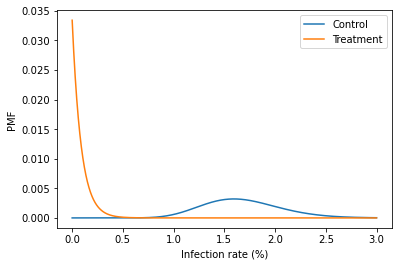

In [9]:
import matplotlib.pyplot as plt

pmf_control.plot(label='Control')
pmf_treatment.plot(label='Treatment')

plt.xlabel('Infection rate (%)')
plt.ylabel('PMF')
plt.legend();

## Computing Efficacy

Now, to compute efficacy, I'll use these distributions to compute the distribution of risk ratio, `RR`, and then compute the distribution of efficacy, which is the complement of risk ration, `1-RR`.

We can use `div_dist` to compute the risk ratio.

In [10]:
pmf_ratio = pmf_treatment.div_dist(pmf_control)

Here's the CDF of the risk ratio.  I cut it off at 1 because higher values have very low probabilities; that is, we are pretty sure the treatment is effective.

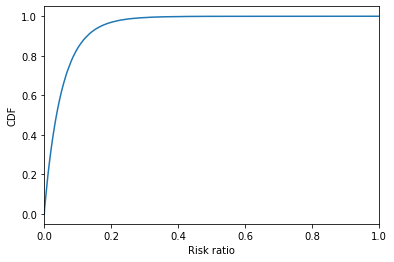

In [11]:
pmf_ratio.make_cdf().plot()
plt.xlim([0, 1])

plt.xlabel('Risk ratio')
plt.ylabel('CDF');

To compute the distribution of efficacy, we have to compute the distribution of `1-RR`, where `RR` is the risk ratio.  We can do that with `empiricaldist` by creating a deterministic `Pmf` with the quantity `1` and using `sub_dist` to subtract two `Pmf`s.

In [12]:
efficacy = Pmf.from_seq(1).sub_dist(pmf_ratio)

Here's the result.

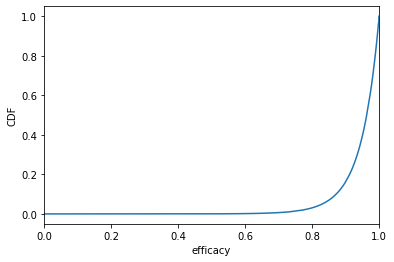

In [13]:
efficacy.make_cdf().plot()
plt.xlim([0, 1])

plt.xlabel('efficacy')
plt.ylabel('CDF');

The posterior mean is about 94%.

In [14]:
efficacy.mean()

0.9449759891115062

And the 95% credible interval is between 79% and 99.9%.


In [15]:
efficacy.credible_interval(0.95)

array([0.78696377, 0.99943336])

By these estimates, the efficacy in teenagers is about the same as in adults.

*If you like this article, you might also like the second edition of [*Think Bayes*](https://greenteapress.com/wp/think-bayes/).*

Copyright 2020 Allen Downey

Code: [MIT License](https://opensource.org/licenses/MIT)

Text: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)